# Pytorch Driven SVD

In [3]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from random import randint

sns.set_theme()

While we've implemented and trained our own version of ASVD, this implementation struggles from two major problems:
1. Speed - Numpy arrays are fairly optimized, but calculating gradients manually still takes a while
2. Flexibility - We have to manually recalculate gradients every time a new change is made to the model infrastructure. This becomes extremely difficult with more complicated loss functions and transforms.

Pytorch solves these problem by allowing **automatic differentiation** through the `autograd` library. This means that whenever two vectors or matrices have some computation performed on them, Pytorch tracks their values and gradients behind the scenes. Then when the gradients need to be calculated for parameters, an algorithm called **backpropagation** is utilized to "backpropagate" the derivatives through all computations tracked.

Note that in order to run the model now, you will have to install Pytorch. This can be done using the command below:
```bash
pip install torch
```

Additionally, to get the most up to date file, you will need to obtain the `data4_01.csv` file from our Google Drive folder. This contains not only all the MovieLens data, but extra metadata parsed from IMDb, plus a fixed index mapping from utility matrix indices for movies and the movies in the dataset. When done, type in the directory to this csv file below:

In [ ]:
path_to_new_data = None

## Implementation

Below is the implementation of the Asymmetric SVD that we've used so far using Pytorch's `nn.Module` class.

In [4]:
class ASVD(torch.nn.Module):
    def __init__(self, num_movies, latent_dim=10):
        super().__init__()
        self.Z = torch.nn.Parameter(torch.randn((num_movies, latent_dim)))
        self.V = torch.nn.Parameter(torch.randn((num_movies, latent_dim)))
        self.item_bias = torch.nn.Parameter(torch.zeros(num_movies,))
        self.rsoftmax = torch.nn.Softmax(dim=1)

    def forward(self, R):
        return self.rsoftmax(R @ self.Z) @ self.V.T + self.item_bias

Some notes about the implementation:
- Pytorch uses the `tensor` class inplace of the regular numpy `ndarray` that has been used so far. Practically, there is very limited difference, at least in the scope of this project.
- Pytorch has a class `nn.Module` that simulates an abstract machine learning model. It has two key features:
    - It stores model parameters that are initialized using `__init__`
    - It processes input predictions using the `forward` function
- The `nn.Parameter` class is used to register $Z$, $V$, and the item bias so that these weights can be saved and loaded from file. This means training is only needed once, and then only model weights are necessary to operate the model.

There are two key design choices that are of note:

### Item Bias
We discussed earlier the importance of a global mean in helping predict new ratings. An item bias works in a similar way - by training a bias term for each movie, the model learns some offsetting factor *per movie* that enables the model to better predict new ratings. Unlike a global mean however, this is learned in the same way $Z$ and $V$ are - through gradient descent.

### Softmax
We softmax the matrix product $RZ \in \mathbb{R}^{n \times k}$ unlike the regular implementation of ASVD. The softmax function is described as an operation on a vector $\vec{x} \in \mathbb{R}^n$ such that $$\text{softmax}(\vec{x}) = \frac{[e^{x_1}, e^{x_2}, \dots, e^{x_n}]}{\sum_{i=1}^n e^{x_i}}$$ which converts the vector into a normalized distribution of scores. In the implementation above, this operation to applies to each row of the $RZ$ matrix.

Why apply softmax? Recall $RZ \approx U$ where $U$ is the original user latent factor matrix in the vanilla implementation of Matrix Factorization recommender systems. However, there are two issues in this case:
- $R$ is generally a sparse matrix, making $U$ dependant on only a few entries in $R$ and $Z$. This means that our latent factor representation of users has missing information which fails to capture all the tendencies of the underlying user. By performing softmax on each row of $RZ$, each entry will be given some nonzero value that can actually be utilized in conjuction with the less sparse $V$ to produce good output predictions
- Without softmax, the magnitude of the predicted rating depended directly on the magnitude of the latent factors. However in asymmetric SVD the magnitude of the latent factors for $U$ depend directly on the ratings in $R$. This meant that users with more ratings would tend to receive a higher predicted value on average. This dependence makes inference time rankings highly variable. By applying softmax to $RZ \approx U$, all latent factors are essentially normalized into $[0,1]$, reducing the influence of rating density on predicted rating.

These are our hypothesis for exactly why softmax works better on this dataset.

## Training

NOTE: Feel free to skip training if you are just reading through the notebook and make sure to run the cell that loads the pretrained model from file.

First step is to obtain the training and testing data

In [8]:
df = pd.read_csv('../../../data/user_rating_matrix.csv', index_col=0)
movies = pd.read_csv('../../../data/ml-latest-small/movies.csv')
cleanedmovies = pd.read_csv(path_to_new_data)
df.columns.name = df.index.name
df.index.name = 'title'
R = torch.from_numpy(df.to_numpy().T).to(torch.float32)
train = R[:500]
test = R[500:]

Below is the training loop applied to train the model. Note the modular design of the optimization algorithm (AdamW, which is similar to SGD), loss function (MSE), and model. This separation is made easy through Pytorch. Visit [this](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html) link to learn in greater detail what each of the steps below actually mean

In [227]:
model = ASVD(9719, latent_dim=100)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_fn = torch.nn.MSELoss()
B = train.shape[0]
train_loss, test_loss = [], []


for i in tqdm(range(10000)):
    optimizer.zero_grad()
    indices = torch.randint(0, B, (128,))
    batched_inputs = train[indices]
    pred = model(batched_inputs)
    l = loss_fn(pred, batched_inputs)
    l.backward()
    optimizer.step()

    train_loss.append(l.item())
    with torch.no_grad():
        val = model(test)
        vl = loss_fn(val, test)
        test_loss.append(vl.item())

100%|██████████| 10000/10000 [18:35<00:00,  8.97it/s]


Below are the loss curves from the training procedure. An interesting fact to note is the slight overfitting observed even with a large weight decay factor, as the test loss curve exceeds the training loss curve for the last few iterations. This suggests further regularization is needed. However, as the overfitting is not excessive, test set results are anticipated to be of good quality.

<AxesSubplot:>

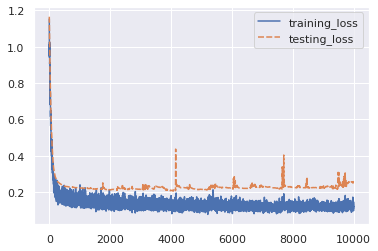

In [228]:
losses = pd.DataFrame({"training_loss":train_loss, "testing_loss":test_loss})
sns.lineplot(data=losses)

## Sanity Check

While the loss being at about ~0.2 is a good sign of a decent prediction performance, it is useful to qualitatively analyze the results of the model to understand if the results are meaningful to the human eye.

NOTE: If you didn't run the training above, run the cell directly below to load the pretrained model weights.

In [5]:
model = ASVD(num_movies=9719, latent_dim=100)
model.load_state_dict(torch.load("./torchsvd.pt"))

<All keys matched successfully>

In [6]:
def get_predictions(index, model):
    preds = model(test[index].view(1,-1)).squeeze()
    top_k = torch.argsort(preds, descending=True)
    actual = torch.argsort(test[index], descending=True).squeeze()
    return actual, top_k

def print_k(iterable, k):
    for idx in iterable[:k]:
        title = cleanedmovies[cleanedmovies["cleaned_mov_id"] == idx.item()]["title"].item()
        genre = movies[movies["title"] == title]["genres"].to_numpy()[0]
        print(f"{title:<75} │ {genre:<25}")
    

In [16]:
index = randint(0,100)
actual, top_k = get_predictions(index, model)

Below are the top 10 movies the user actually rated

In [17]:
print_k(actual, 10)

Star Wars: Episode V - The Empire Strikes Back (1980)                       │ Action|Adventure|Sci-Fi  
12 Angry Men (1957)                                                         │ Drama                    
2001: A Space Odyssey (1968)                                                │ Adventure|Drama|Sci-Fi   
Casablanca (1942)                                                           │ Drama|Romance            
Some Like It Hot (1959)                                                     │ Comedy|Crime             
Planet of the Apes (1968)                                                   │ Action|Drama|Sci-Fi      
Snow White and the Seven Dwarfs (1937)                                      │ Animation|Children|Drama|Fantasy|Musical
Wizard of Oz, The (1939)                                                    │ Adventure|Children|Fantasy|Musical
Miracle on 34th Street (1947)                                               │ Comedy|Drama             
Lord of the Rings: The Two Towers, The (

Below are the top 20 movies recommended by the algorithm to the user

In [18]:
print_k(top_k, 20)

Toy Story 2 (1999)                                                          │ Adventure|Animation|Children|Comedy|Fantasy
E.T. the Extra-Terrestrial (1982)                                           │ Children|Drama|Sci-Fi    
Shrek (2001)                                                                │ Adventure|Animation|Children|Comedy|Fantasy|Romance
Beauty and the Beast (1991)                                                 │ Animation|Children|Fantasy|Musical|Romance|IMAX
Wizard of Oz, The (1939)                                                    │ Adventure|Children|Fantasy|Musical
Sound of Music, The (1965)                                                  │ Musical|Romance          
Mary Poppins (1964)                                                         │ Children|Comedy|Fantasy|Musical
West Side Story (1961)                                                      │ Drama|Musical|Romance    
Lion King, The (1994)                                                       │ Adventure

If you run the cells above multiple times, you will notice a slight problem - the same few movies tend to be recommended more often than not. This is likely caused by the **long tail problem**. Many more people have watched and highly rated movies like *The Dark Knight* than movies like *Elite Squad*. As a result, the recommender system is more likely to identify the former as a movie that a user is more likely to watch. There is no easy solution for the long tail problem, which requires careful inspection and methodology (that which we don't have time for).

## Latent Space Analysis

By looking at the top ranked movies in each latent dimension, some intuition about those movies can be extracted.

In [244]:
top = model.Z[:,1].argsort(descending=True)
print_k(top, 25)

Net, The (1995)                                                             │ Action|Crime|Thriller    
Babe (1995)                                                                 │ Children|Drama           
Wallace & Gromit: A Close Shave (1995)                                      │ Animation|Children|Comedy
Boot, Das (Boat, The) (1981)                                                │ Action|Drama|War         
No Country for Old Men (2007)                                               │ Crime|Drama              
Inland Empire (2006)                                                        │ Drama|Mystery|Thriller   
Alphaville (Alphaville, une étrange aventure de Lemmy Caution) (1965)       │ Drama|Mystery|Romance|Sci-Fi|Thriller
Bad Boy Bubby (1993)                                                        │ Drama                    
Topo, El (1970)                                                             │ Fantasy|Western          
Easy Rider (1969)                                   

For example, the model observed that the movie above tended to be related in some fashion, and so were ranked highly in their respect latent space dimension. A starting hypothesis from the limited sample here suggests that movies of the genre *Drama* are more heavily represented. It is more likely though there is a more subtle relationship that is less interpretable by human observers.

Some suggested analysis steps are:
- Look at the distribution of genres among highly scoring movies per latent space dimension
- Look at the distribution of years among highly scoring movies per latent space dimension
- There is alot of other metadata stored in the `data4_01.csv` file (stored in our Google Drive folder) - study the relationships between that metadata and the movies in each latent space.

Try drawing conclusions from your observations here!

## Save Model

To use the model for later inference, we will save the model dictionary to file.

In [245]:
torch.save(model.state_dict(), "./torchsvd.pt")

Then to reload the model, it suffices to run the following code block (make sure the settings for `num_movies` and `latent_dim` are exactly the same!)

In [ ]:
model = ASVD(num_movies=9719, latent_dim=100)
model.load_state_dict(torch.load("./torchsvd.pt"))